In [31]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
# import torch
# import torch.distributions.categorical
import scipy
import scipy.stats
import math


30
0.9999992102698403 True


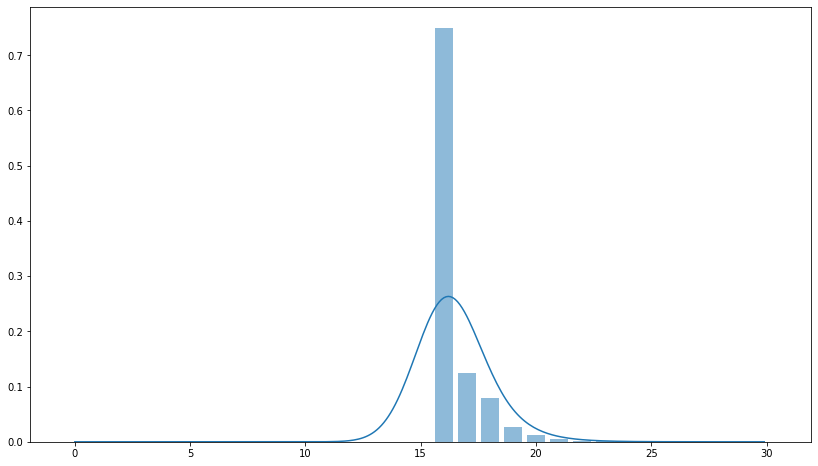

In [32]:
dist = pd.read_csv('distr.csv')
#dist.head(10)
rx = dist['r'].to_numpy()
rp = dist['p'].to_numpy()
n = np.max(np.where(rp > 1e-6))
rx = rx[0:n+1]
rp = rp[0:n+1]
print(n)
print(np.sum(rp), np.allclose(np.sum(rp), 1))
distr = scipy.stats.rv_discrete(values=(rx, rp))
# h = plt.bar(rx, rp, alpha=0.5)
plt.figure(figsize=(14,8))
h = plt.bar(rx, distr.pmf(rx), alpha=0.5)
kernel = scipy.stats.gaussian_kde(rx, weights=rp)
range = np.arange(0, n, 0.1)
plt.plot(range, kernel(range))
# plt.fill_between(range, kernel(range))

33
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.78703704e-01
 2.29070216e-01 1.16544496e-01 4.48205125e-02 1.86612595e-02
 7.31542768e-03 2.93988613e-03 1.16755078e-03 4.66782538e-04
 1.86230630e-04 7.44189843e-05 2.97284306e-05 1.18800100e-05
 4.74723078e-06 1.89713229e-06]


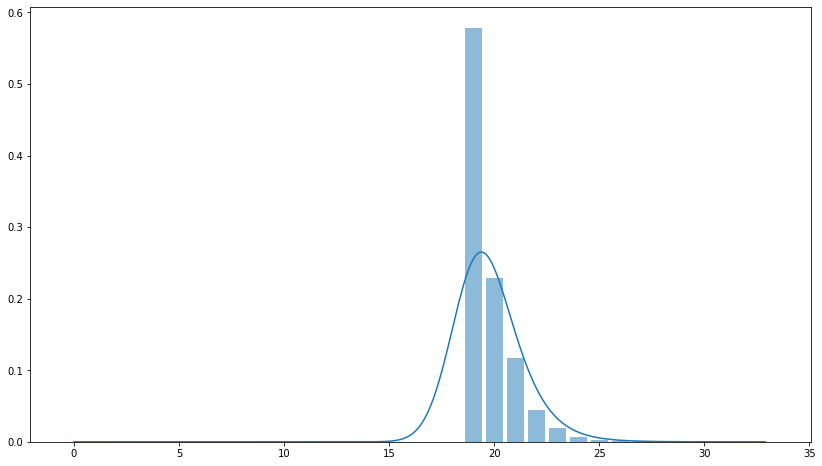

In [30]:
dist = pd.read_csv('distr.csv')
#dist.head(10)
rx = dist['r'].to_numpy()
rp = dist['p'].to_numpy()
n = np.max(np.where(rp > 1e-6))
rx = rx[0:n+1]
rp = rp[0:n+1]
print(n)
print(rp.flatten())
distr = scipy.stats.rv_discrete(values=(rx, rp))
# h = plt.bar(rx, rp, alpha=0.5)
plt.figure(figsize=(14,8))
h = plt.bar(rx, distr.pmf(rx), alpha=0.5)
kernel = scipy.stats.gaussian_kde(rx, weights=rp)
range = np.arange(0, n, 0.1)
plt.plot(range, kernel(range))
# plt.fill_between(range, kernel(range))

In [24]:
arr = np.array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.579, 0.229, 0.117, 0.045, 0.019, 0.007, 0.003, 0.001, 0.000, 0.000, 0.000, 0.000])

(0.0, 0.6)

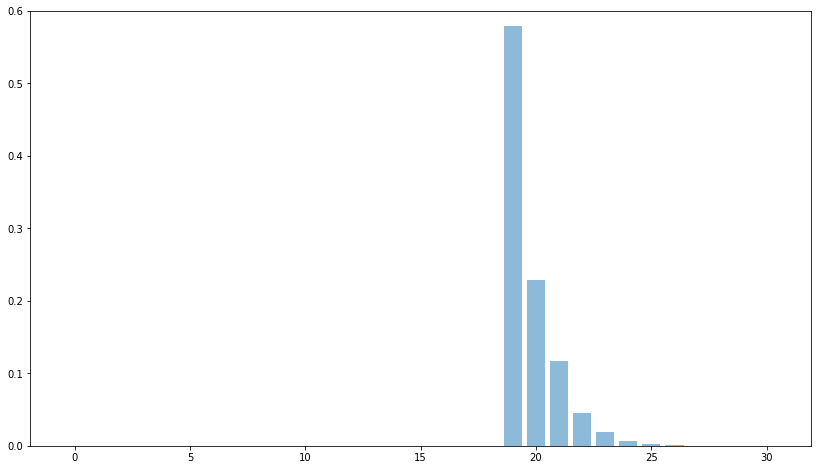

In [25]:
plt.figure(figsize=(14,8))
plt.bar(np.arange(31),arr[:31], alpha=0.5)
plt.ylim([0, 0.6])

In [22]:
arr = np.array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.921, 0.000, 0.000, 0.000, 0.014, 0.016, 0.006, 0.016, 0.008, 0.005, 0.004, 0.005, 0.001, 0.001, 0.002, 0.000 ])

(0.0, 1.2)

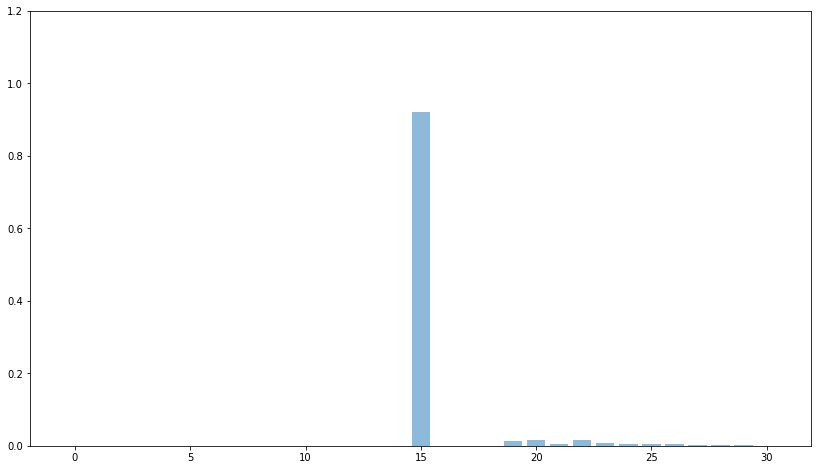

In [23]:
plt.figure(figsize=(14,8))
plt.bar(np.arange(31),arr[:31], alpha=0.5)
plt.ylim([0, 1.2])

In [8]:
arr = np.array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.168, 0.101, 0.045, 0.018, 0.007, 0.002, 0.243, 0.146, 0.065, 0.072, 0.037, 0.016, 0.027, 0.015, 0.006, 0.011, 0.006, 0.003, 0.004, 0.002, 0.001, 0.002, 0.001, 0.000, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000])

(0.0, 0.25)

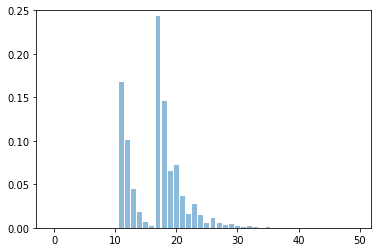

In [10]:
plt.bar(np.arange(50),arr[:50], alpha=0.5)
plt.ylim([0, 0.25])

In [22]:
arr2 = np.array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.341, 0.207, 0.228, 0.103, 0.068, 0.028, 0.014, 0.006, 0.003, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000])

In [23]:
arr2.shape

(201,)

(0.0, 130.0)

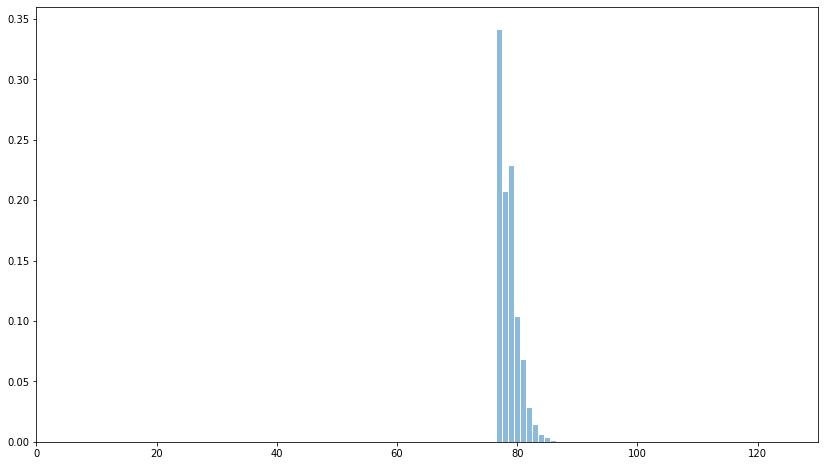

In [25]:
plt.figure(figsize=(14,8))
plt.bar(np.arange(201),arr2, alpha=0.5)
plt.ylim([0, 0.36])
plt.xlim([0, 130])

In [12]:
arr_qr = np.array([37.000, 37.000, 37.000, 37.000, 37.000, 37.000, 39.000, 39.000, 39.000, 39.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 52.000, 52.000, 52.000, 52.000, 52.000, 52.000, 53.000, 53.000, 53.000, 53.000, 53.000, 53.000, 53.000, 53.000, 53.000, 54.000, 54.000, 55.000, 55.000, 55.000, 55.000, 56.000, 57.000, 57.000, 59.000, 59.000, 59.000, 60.000, 61.000, 61.000, 61.000, 61.000, 61.000, 61.000, 61.000, 62.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 67.000, 67.000, 67.000, 67.000, 67.000, 67.000, 67.000, 67.000, 68.000, 69.000, 69.000, 69.000, 69.000, 70.000, 70.000, 71.000, 71.000, 71.000, 71.000, 73.000, 73.000, 79.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 88.000, 88.000, 88.000, 88.000, 88.000, 88.000, 88.000, 88.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 90.000, 90.000, 90.000, 91.000, 91.000, 91.000, 91.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 93.000, 93.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 95.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 97.000, 97.000, 98.000, 98.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 100.000, 100.000, 100.000, 100.000, 100.000, 100.000, 100.000, 100.000, 101.000, 101.000, 101.000, 101.000, 101.000, 101.000, 101.000, 101.000, 101.000, 102.000, 102.000, 102.000, 102.000, 102.000, 102.000, 102.000, 103.000, 103.000, 103.000, 103.000, 103.000, 103.000, 103.000, 103.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 105.000, 105.000, 105.000, 105.000, 105.000, 105.000, 105.000, 105.000, 106.000, 106.000, 106.000, 106.000, 106.000, 106.000, 107.000, 107.000, 107.000, 107.000, 107.000, 107.000, 107.000, 107.000, 107.000, 108.000, 108.000, 108.000, 109.000, 109.000, 109.000, 109.000, 109.000, 110.000, 111.000, 111.000, 111.000, 111.000, 111.000])

In [13]:
atoms = 1000
delta_p = 1.0/atoms
arr_conv = np.zeros(201)

for j in np.arange(atoms):
    val = arr_qr[j]
    low = math.floor(val)
    upp = math.ceil(val)
    if low - upp != 0:
        arr_conv[low] += (val - low) * delta_p
        arr_conv[upp] += (upp - val) * delta_p
    else:
        arr_conv[low] += delta_p
    
arr_conv

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.006, 0.   , 0.004, 0.   , 0.082, 0.014, 0.14 , 0.023,
       0.131, 0.021, 0.084, 0.017, 0.043, 0.01 , 0.016, 0.006, 0.009,
       0.002, 0.004, 0.001, 0.002, 0.   , 0.003, 0.001, 0.007, 0.001,
       0.012, 0.   , 0.013, 0.   , 0.008, 0.001, 0.004, 0.002, 0.004,
       0.   , 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   ,
       0.019, 0.024, 0.027, 0.028, 0.028, 0.014, 0.023, 0.008, 0.013,
       0.003, 0.004, 0.013, 0.002, 0.01 , 0.001, 0.012, 0.002, 0.002,
       0.014, 0.008, 0.009, 0.007, 0.008, 0.01 , 0.008, 0.006, 0.009,
       0.003, 0.005, 0.001, 0.005, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ,

(0.0, 130.0)

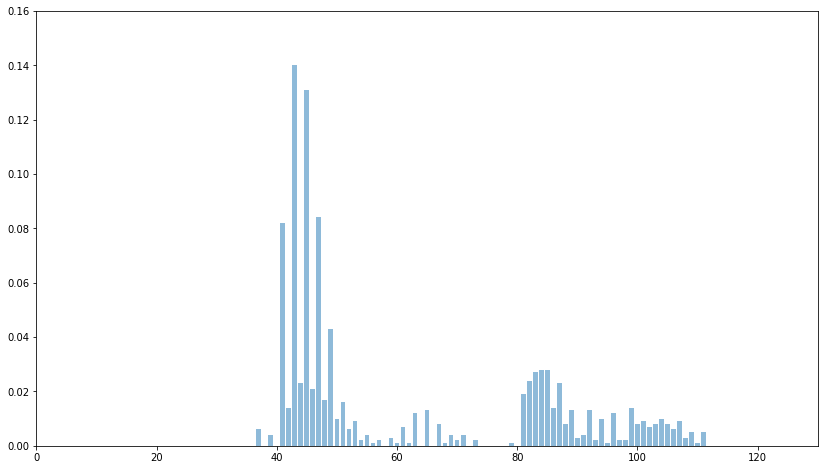

In [14]:
plt.figure(figsize=(14,8))
plt.bar(np.arange(201),arr_conv, alpha=0.5)
plt.ylim([0, 0.16])
plt.xlim([0,130])

In [15]:
delta_p

0.001

In [26]:
arr3 = np.array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.004, 0.031, 0.102, 0.196, 0.243, 0.207, 0.126, 0.059, 0.022, 0.007, 0.002, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000])

In [27]:
vmax = 400
atoms=201

(0.0, 130.0)

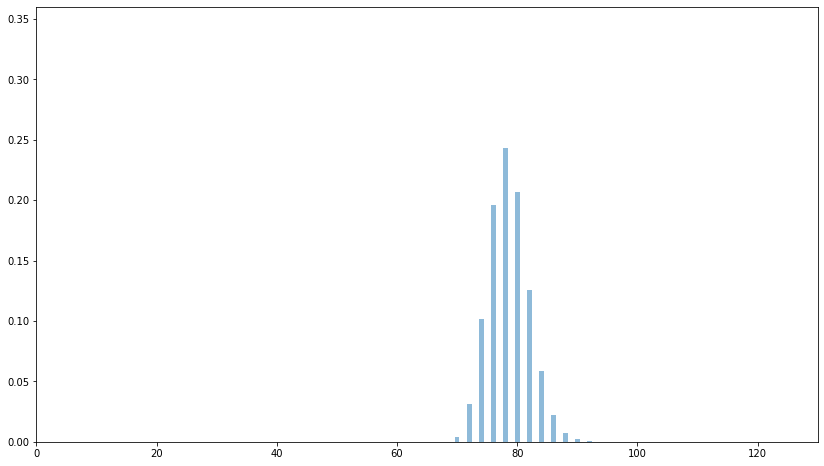

In [28]:
plt.figure(figsize=(14,8))
plt.bar(np.arange(0,200,2),arr3[:100], alpha=0.5)
plt.ylim([0, 0.36])
plt.xlim([0, 130])